In [1]:
import nltk
from nltk.corpus import brown
from nltk.tag import hmm
from sklearn.model_selection import train_test_split

# Step 2: Load the Brown corpus with the universal tagset
nltk.download("brown")

In [2]:
nltk.download('universal_tagset')

nltk.download('punkt')

In [3]:
# Load the Brown corpus with universal tagset
corpus = brown.tagged_sents(tagset="universal")


In [7]:
from collections import defaultdict
import numpy as np
# my_dict = defaultdict(int)  # Default value for new keys is 0 (int)

class HMM_Model():
    def __init__(self,train_data,smoothing_parameter=0) -> None:
        self.data = train_data
        self.words = defaultdict(int)
        self.tags = defaultdict(int)
        self.transition = []
        self.emission = []
        self.smoothing_parameter = smoothing_parameter

    def get_words_tag(self):
        # print(self.data[0])
        for sentence in self.data:
            for word,tag in sentence:
                word = word.lower()
                if word not in self.words.keys():
                    self.words[word] = len(self.words)
                if tag not in self.tags.keys():
                    self.tags[tag] = len(self.tags) + 1
        self.tags['START'] = 0

    def train(self):
        self.get_words_tag()
        self.transition = np.zeros((len(self.tags), len(self.tags)))
        self.emission = np.zeros((len(self.words), len(self.tags)))

        for sentence in self.data:
            last = None
            for word, tag in sentence:
                
                word = word.lower()
                if last is None:
                    last = 'START'

                prev_ind, cur_ind, word_ind = self.tags[last], self.tags[tag], self.words[word]

                # Apply Laplace smoothing to transition and emission counts
                self.transition[prev_ind][cur_ind] += 1
                self.emission[word_ind][cur_ind] += 1

                last = tag
            
        # Apply Laplace smoothing to normalize probabilities
        # Smoothing parameter is added to both numerator and denominator
        self.transition = (self.transition + self.smoothing_parameter) / (self.transition.sum(axis=1) + len(self.tags) * self.smoothing_parameter)[:, np.newaxis]
        self.emission = (self.emission + self.smoothing_parameter) / (self.emission.sum(axis=0) + len(self.words) * self.smoothing_parameter)[np.newaxis, :]
   
    def viterbi(self,tokens):
        n = len(tokens)
        m = len(self.tags)
        dp = np.zeros((n, m))
        backpointers = np.zeros((n, m), dtype=int)

        for j in range(m):
            word_idx = self.words.get(tokens[0], -1)
            emission_prob = self.emission[word_idx][j] if word_idx != -1 else 1.0 
            dp[0][j] = self.transition[self.tags['START']][j] * emission_prob
            # dp[0][j] = self.transition[self.tags['START']][j] * self.emission[self.words.get(tokens[0], -1)][j]

        # Fill in the dynamic programming table
        for i in range(1, n):
            for j in range(m):
                max_prob = -1
                max_prev = -1
                for k in range(m):
                    word_idx = self.words.get(tokens[i], -1)
                    emission_prob = self.emission[word_idx][j] if word_idx != -1 else 1.0  # Unknown word
                    prob = dp[i - 1][k] * self.transition[k][j] * emission_prob
                    if prob > max_prob:
                        max_prob = prob
                        max_prev = k
                dp[i][j] = max_prob
                backpointers[i][j] = max_prev

        # Find the best sequence of tags using backpointers
        best_sequence = [0] * n
        best_sequence[n - 1] = np.argmax(dp[n - 1])
        for i in range(n - 2, -1, -1):
            best_sequence[i] = backpointers[i + 1][best_sequence[i + 1]]

        # Map tag indices back to tag labels
        tags = [list(self.tags.keys())[list(self.tags.values()).index(tag_idx)] for tag_idx in best_sequence]

        return tags  

# 1-Fold for the inference

In [4]:
train_data, test_data = train_test_split(corpus, test_size=0.1, random_state=42)

In [8]:
Model = HMM_Model(train_data,0.1)

In [9]:
# Model.train()
Model.train()

In [32]:
import string

def word_tokenize(sentence):
    punctuation = string.punctuation

    tokens = []
    current_word = ""

    for char in sentence:
        # If the character is not a space or punctuation mark, add it to the current word
        if char not in string.whitespace and char not in punctuation:
            current_word += char
        else:
            # If the current word is not empty, add it to the list of tokens
            if current_word:
                tokens.append(current_word.lower())  # Convert to lowercase
            if char != ' ':
                    current_word = char
                    tokens.append(current_word.lower())  # Convert to lowercase
            current_word = ""

    # Add the last word if it exists
    if current_word:
        tokens.append(current_word.lower())  # Convert to lowercase

    return tokens

In [37]:
sentence = "This is samples!"
tokens = word_tokenize(sentence)  # Tokenize the input sentence
print(tokens)
tagged_sentence = Model.viterbi(tokens)

print(tagged_sentence)

['this', 'is', 'samples', '!']
['DET', 'VERB', 'NOUN', '.']


In [38]:
def predict(sentence):
    tokens = word_tokenize(sentence) 
    tagged_sentence = Model.viterbi(tokens)
    return tokens,tagged_sentence

In [ ]:
# !pip install gradio

In [12]:
import gradio as gr

c:\Users\ASUS\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
demo = gr.Interface(fn=predict, inputs="text", outputs=["text","text"],output_labels=["tokens", "POS_Tags"])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21892\3332420833.py:1: GradioUnusedKwargWarning: You have unused kwarg parameters in Interface, please remove them: {'output_labels': ['tokens', 'POS_Tags']}
  demo = gr.Interface(fn=predict, inputs="text", outputs=["text","text"],output_labels=["tokens", "POS_Tags"])


In [40]:
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [41]:
from sklearn.metrics import confusion_matrix,accuracy_score

all_predicted_tags = []
all_ground_truth_tags = []

for sentence in test_data:
    tokens =  [tup[0].lower() for tup in sentence]
    tag_GT = [tup[1] for tup in sentence]

    tagged_sentence = Model.viterbi(tokens)

    all_predicted_tags.extend(tagged_sentence)
    all_ground_truth_tags.extend(tag_GT)
    # print("Model Prediction: ", tagged_sentence)
    # print("Ground Truth:", tag_GT)
    accuracy = accuracy_score(tag_GT, tagged_sentence)
    # print(accuracy)
    # break


In [43]:
from sklearn.metrics import accuracy_score 

unique_tags = np.unique(list(Model.tags.keys()))

confusion = confusion_matrix(all_ground_truth_tags, all_predicted_tags, labels=unique_tags)

# Calculate the accuracy
accuracy = accuracy_score(all_ground_truth_tags, all_predicted_tags)

# Print the confusion matrix
# print("Confusion Matrix:")
# print(confusion)

# Print the accuracy
print("Accuracy:", accuracy*100)

Accuracy: 95.73995928673149


# **Viterbi and K-fold method**

In [44]:
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds,random_state=42,shuffle=True)
# kf = KFold(n_splits=n_folds)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

In [77]:
unique_tags = ['DET',
 'NOUN',
 'ADJ',
 'VERB',
 'ADP',
 '.',
 'ADV',
 'CONJ',
 'PRON',
 'PRT',
 'NUM',
 'X']

In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import precision_recall_fscore_support

fold_accuracies = []
fold_confusion_matrices = []
precisions = []
recalls = []
f1_scores = []
per_pos_precision = {}
per_pos_recall = {}
per_pos_f1 = {}
# Initialize dictionary to store per POS accuracy
fold_per_pos_accuracy = []
f05_scores = []
f2_scores = []

for train_indices, test_indices in tqdm(kf.split(corpus), total=n_folds, desc="Cross-validation"):
    # Split the data into train and test sets for this fold
    train_data = [corpus[i] for i in train_indices]
    test_data = [corpus[i] for i in test_indices]

    # Train your model on the training data
    model = HMM_Model(train_data,0.1)
    model.train()

    all_ground_truth_tags = []
    all_predicted_tags = []

    # Perform predictions on the test data
    for sentence in test_data:
        tokens = [tup[0].lower() for tup in sentence]
        tag_GT = [tup[1] for tup in sentence]

        # Predict tags using your model
        predicted_tags = model.viterbi(tokens)

        # Extend the lists with the predicted and ground truth tags for this fold
        all_ground_truth_tags.extend(tag_GT)
        all_predicted_tags.extend(predicted_tags)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(all_ground_truth_tags, all_predicted_tags)
    fold_accuracies.append(accuracy)

    precision = precision_score(all_ground_truth_tags, all_predicted_tags, average='weighted',zero_division=1)
    recall = recall_score(all_ground_truth_tags, all_predicted_tags, average='weighted',zero_division=1)
    f1 = f1_score(all_ground_truth_tags, all_predicted_tags, average='weighted',zero_division=1)
    f05 = fbeta_score(all_ground_truth_tags, all_predicted_tags, beta=0.5, average='weighted',zero_division=1)
    f2 = fbeta_score(all_ground_truth_tags, all_predicted_tags, beta=2, average='weighted',zero_division=1)

    # Append the metrics to the respective lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    f05_scores.append(f05)
    f2_scores.append(f2)


    precision, recall, f1, support = precision_recall_fscore_support(all_ground_truth_tags, all_predicted_tags, labels=list(model.tags.keys()),zero_division=1)

    # Update the dictionaries with per-POS metrics for this fold
    for i, pos_tag in enumerate(list(model.tags.keys())):
        per_pos_precision[pos_tag] = per_pos_precision.get(pos_tag, 0) + precision[i]
        per_pos_recall[pos_tag] = per_pos_recall.get(pos_tag, 0) + recall[i]
        per_pos_f1[pos_tag] = per_pos_f1.get(pos_tag, 0) + f1[i]

    # Calculate confusion matrix for this fold
    unique_tags = np.unique(unique_tags)
    confusion = confusion_matrix(all_ground_truth_tags, all_predicted_tags, labels=unique_tags)
    fold_confusion_matrices.append(confusion)


    per_pos_accuracy = {}

    # Calculate per POS accuracy for this fold
    for tag in unique_tags:
        tag_indices = [i for i, t in enumerate(all_ground_truth_tags) if t == tag]
        per_pos_accuracy[tag] = accuracy_score(
            [all_ground_truth_tags[i] for i in tag_indices],
            [all_predicted_tags[i] for i in tag_indices]
        )
    
    fold_per_pos_accuracy.append(per_pos_accuracy)

Cross-validation: 100%|██████████| 5/5 [03:47<00:00, 45.54s/it]


In [79]:
# Calculate the average metrics across all folds
average_precision = sum(precisions) / n_folds
average_recall = sum(recalls) / n_folds
average_f1 = sum(f1_scores) / n_folds
average_f05 = sum(f05_scores) / n_folds
average_f2 = sum(f2_scores) / n_folds

print("Overall System Performance (5-fold cross-validation):")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-score: {average_f1:.4f}")
print(f"Average F0.5-score: {average_f05:.4f}")
print(f"Average F2-score: {average_f2:.4f}")

Overall System Performance (5-fold cross-validation):
Average Precision: 0.9563
Average Recall: 0.9560
Average F1-score: 0.9560
Average F0.5-score: 0.9562
Average F2-score: 0.9560


In [80]:
num_folds = len(precisions)  # Assuming you already have the list of fold-wise metrics
tags = list(fold_per_pos_accuracy[0].keys())
for pos_tag in tags:
    per_pos_precision[pos_tag] /= num_folds
    per_pos_recall[pos_tag] /= num_folds
    per_pos_f1[pos_tag] /= num_folds

In [81]:
for pos_tag in model.tags.keys():
    if pos_tag=='START':
        continue
    print(f"POS Tag: {pos_tag}")
    print(f"Average Precision: {per_pos_precision[pos_tag]:.4f}")
    print(f"Average Recall: {per_pos_recall[pos_tag]:.4f}")
    print(f"Average F1-score: {per_pos_f1[pos_tag]:.4f}")

POS Tag: DET
Average Precision: 0.9561
Average Recall: 0.9869
Average F1-score: 0.9712
POS Tag: NOUN
Average Precision: 0.9618
Average Recall: 0.9461
Average F1-score: 0.9539
POS Tag: ADJ
Average Precision: 0.9107
Average Recall: 0.9118
Average F1-score: 0.9113
POS Tag: VERB
Average Precision: 0.9746
Average Recall: 0.9448
Average F1-score: 0.9594
POS Tag: ADP
Average Precision: 0.9488
Average Recall: 0.9679
Average F1-score: 0.9582
POS Tag: .
Average Precision: 0.9800
Average Recall: 0.9995
Average F1-score: 0.9897
POS Tag: ADV
Average Precision: 0.9069
Average Recall: 0.8941
Average F1-score: 0.9004
POS Tag: CONJ
Average Precision: 0.9899
Average Recall: 0.9934
Average F1-score: 0.9916
POS Tag: PRON
Average Precision: 0.9524
Average Recall: 0.9838
Average F1-score: 0.9679
POS Tag: PRT
Average Precision: 0.9068
Average Recall: 0.8958
Average F1-score: 0.9012
POS Tag: NUM
Average Precision: 0.9691
Average Recall: 0.9114
Average F1-score: 0.9394
POS Tag: X
Average Precision: 0.6690
Aver

In [82]:
# Reporting results for each fold
for i in range(1,n_folds+1):
    print(f"Fold {i}:")
    print(f"Accuracy: {fold_accuracies[i-1]}")
    
    # Print the confusion matrix for this fold
    print("Confusion Matrix:")
    # print(fold_confusion_matrices[i-1])
    
    # Print per POS accuracy for this fold
    print("Per POS Accuracy:")
    for tag, accuracy in fold_per_pos_accuracy[i-1].items():
        if tag=='START':
            continue
        print(f"{tag}: {accuracy}")
    
    print("\n")

# Calculate and report mean results across folds
mean_accuracy = np.mean(fold_accuracies)
print(f"Mean Accuracy Across Folds: {mean_accuracy}")

# Calculate and report the mean confusion matrix across folds
mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
print("Mean Confusion Matrix Across Folds:")
print(mean_confusion_matrix)

# Calculate and report the mean per POS accuracy across folds
cumulative_per_pos_accuracy = {}

# Calculate cumulative per POS accuracy across folds
for fold_accuracy in fold_per_pos_accuracy:
    for tag, accuracy in fold_accuracy.items():
        if tag not in cumulative_per_pos_accuracy:
            cumulative_per_pos_accuracy[tag] = []
        cumulative_per_pos_accuracy[tag].append(accuracy)

# Calculate the mean per POS accuracy across folds
mean_per_pos_accuracy = {tag: np.mean(acc_list) for tag, acc_list in cumulative_per_pos_accuracy.items()}

# Print the mean per POS accuracy
print("Mean Per POS Accuracy Across Folds:")
for tag, accuracy in mean_per_pos_accuracy.items():
    if tag=='START':
        continue
    print(f"{tag}: {accuracy}")

Fold 1:
Accuracy: 0.9561155018604992
Confusion Matrix:
Per POS Accuracy:
.: 0.9991192411924119
ADJ: 0.912771285475793
ADP: 0.9667686318131257
ADV: 0.8945967527282406
CONJ: 0.9913667153672466
DET: 0.9872970808764651
NOUN: 0.9469191200612893
NUM: 0.9048436963242872
PRON: 0.9841956915643245
PRT: 0.9044934221766615
VERB: 0.9449433921184411
X: 0.3768996960486322


Fold 2:
Accuracy: 0.9561871771340925
Confusion Matrix:
Per POS Accuracy:
.: 0.9994888919176775
ADJ: 0.9121710921542713
ADP: 0.9685166706809345
ADV: 0.8955848317607263
CONJ: 0.9923861143373338
DET: 0.9869892551714056
NOUN: 0.9448284597568037
NUM: 0.9097569097569097
PRON: 0.9840242669362993
PRT: 0.8975535168195719
VERB: 0.946011392091577
X: 0.5365079365079365


Fold 3:
Accuracy: 0.9559839594472606
Confusion Matrix:
Per POS Accuracy:
.: 0.9994205862304022
ADJ: 0.9095913360856818
ADP: 0.9682727843246636
ADV: 0.8929376747542167
CONJ: 0.9927478902953587
DET: 0.9855698258045468
NOUN: 0.9470945675508496
NUM: 0.9120079391333112
PRON: 0.983

<Figure size 500x500 with 0 Axes>

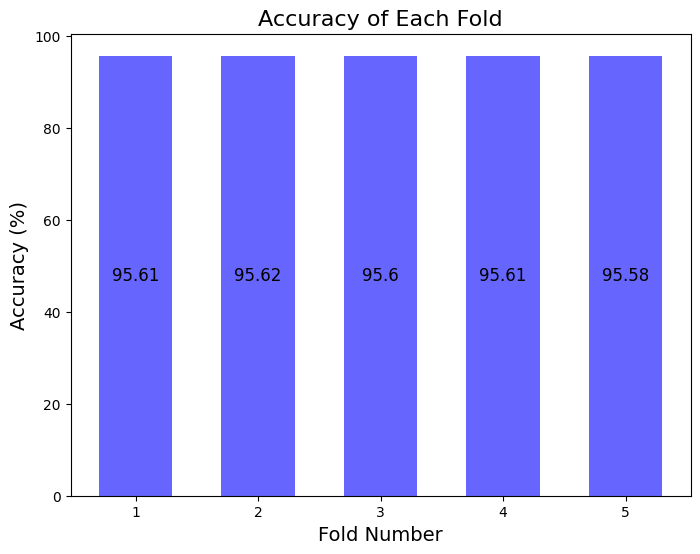

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt


fold_accuracies_graph = [round(accuracy * 100, 2) for accuracy in fold_accuracies]


fold_numbers = list(range(1, 6))  # Assuming you have 5 folds

plt.figure(figsize=(5, 5))
# Create a function to annotate the bars with their values
def annotate_bars(ax, values):
    for i, v in enumerate(values):
        ax.text(i + 1, v / 2, str(v), ha='center', va='center', fontsize=12)

bar_width = 0.6  # 

# Draw a bar plot for accuracy of each fold
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(fold_numbers, fold_accuracies_graph, color='blue', alpha=0.6,width=bar_width)
ax.set_xlabel('Fold Number', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_title('Accuracy of Each Fold', fontsize=16)
ax.set_xticks(fold_numbers)

# Annotate the bars with accuracy values in the middle
annotate_bars(ax, fold_accuracies_graph)

plt.show()

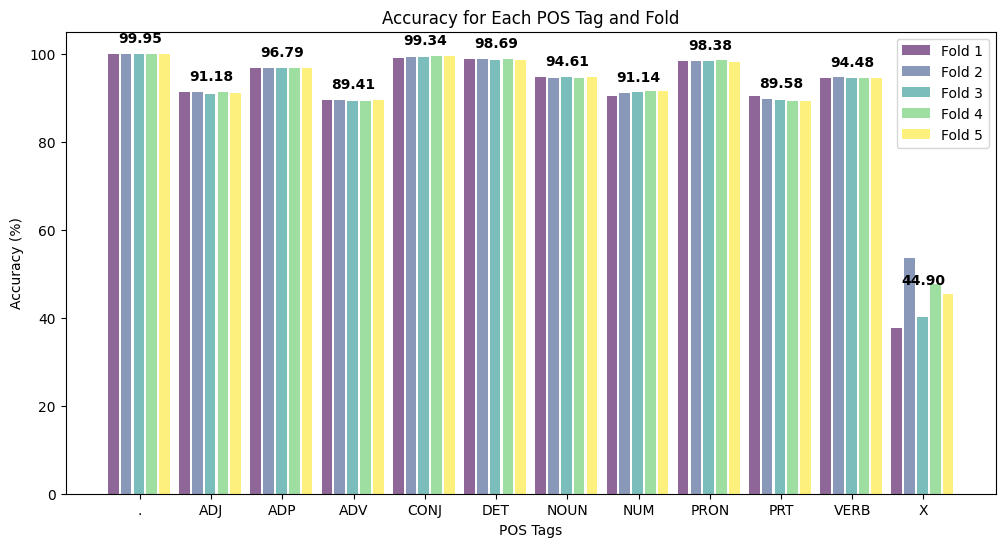

In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already collected fold_per_pos_accuracy

# Create a list of POS tags and fold numbers
tags = list(fold_per_pos_accuracy[0].keys())
fold_numbers = list(range(1, 6))  # Assuming you have 5 folds

# Create a list to store per POS category accuracy for each fold
per_pos_accuracies = [[fold_accuracy[tag] * 100 for fold_accuracy in fold_per_pos_accuracy] for tag in tags]

# Calculate the mean accuracy for each POS tag
mean_accuracies = [np.mean(accuracy) for accuracy in per_pos_accuracies]

# Set bar width and the gap between bars
bar_width = 0.15  # Adjust this value for the desired bar width
bar_gap = 0.03

# Calculate positions for each set of bars
bar_positions = np.arange(len(tags))

# Create a color map for bars
colors = plt.cm.viridis(np.linspace(0, 1, len(fold_numbers)))

# Create the bar plot
plt.figure(figsize=(12, 6))

for i, fold_num in enumerate(fold_numbers):
    plt.bar(
        bar_positions + i * (bar_width + bar_gap),
        [accuracy[i] for accuracy in per_pos_accuracies],
        label=f'Fold {fold_num}',
        width=bar_width,
        color=colors[i],
        alpha=0.6,
    )

# Annotate with the mean accuracy above each POS
for i, mean_accuracy in enumerate(mean_accuracies):
    plt.text(
        bar_positions[i] + (bar_width * len(fold_numbers) / 2),
        mean_accuracy + 2,  # Adjust this value for proper positioning
        f'{mean_accuracy:.2f}',  # Display mean accuracy
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
    )

plt.xlabel('POS Tags')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each POS Tag and Fold')
plt.xticks(bar_positions + (bar_width * len(fold_numbers) / 2), tags)
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

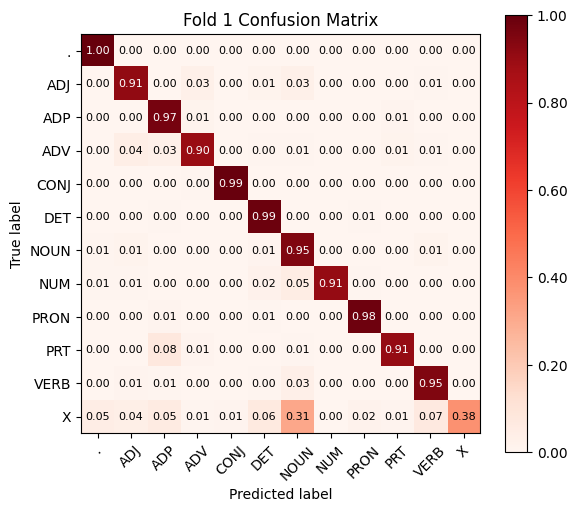

<Figure size 640x480 with 0 Axes>

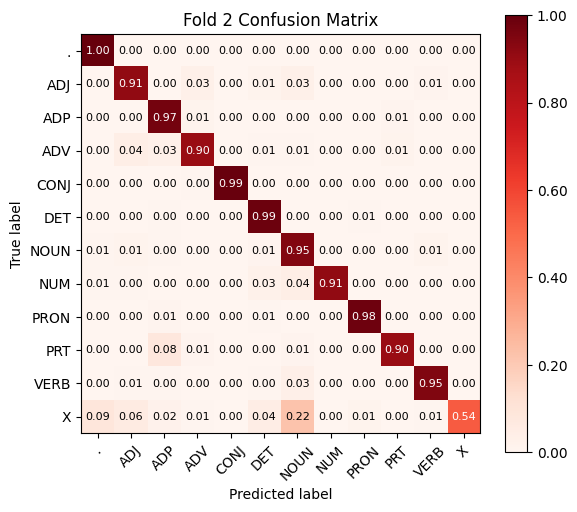

<Figure size 640x480 with 0 Axes>

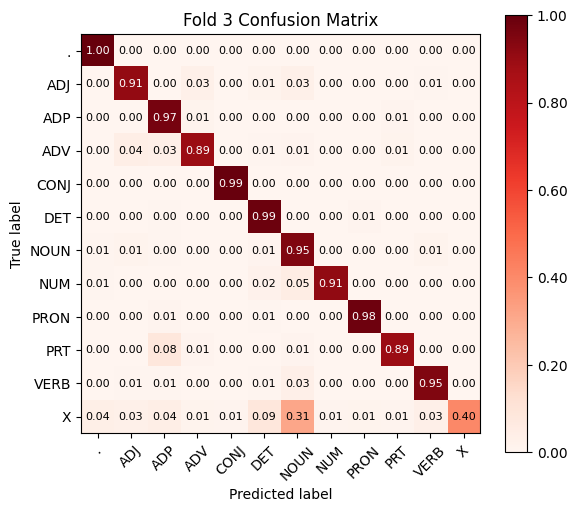

<Figure size 640x480 with 0 Axes>

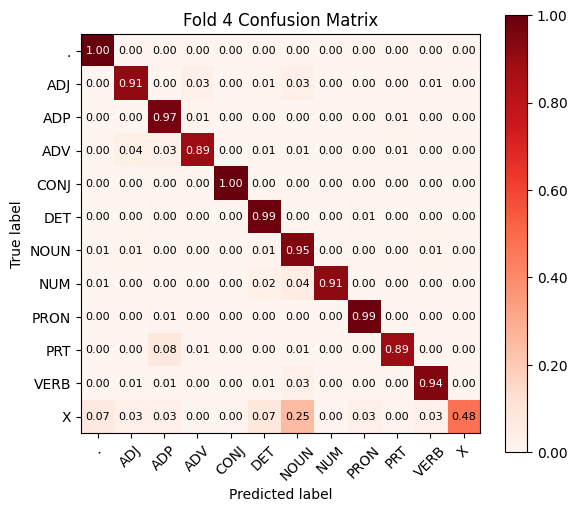

<Figure size 640x480 with 0 Axes>

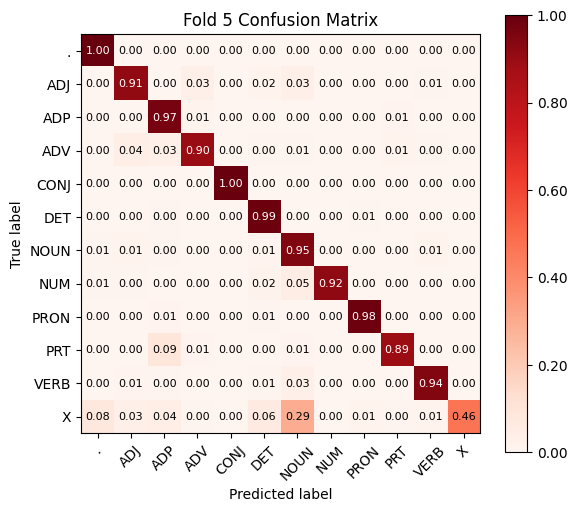

<Figure size 640x480 with 0 Axes>

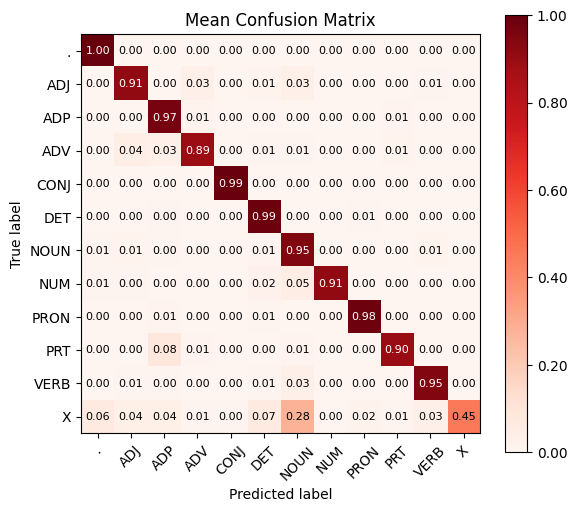

In [89]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Assuming you have already collected fold_confusion_matrices and fold_numbers

# Define the classes (POS tags)
classes = list(mean_per_pos_accuracy.keys())

# Create a function to plot the normalized confusion matrix as a heatmap
def plot_normalized_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    # Normalize the confusion matrix by row sums
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 6))
    im = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar(im, shrink=0.8, format='%.2f')  # Colorbar with values in [0, 1]
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = cm_normalized[i, j]
            plt.text(j, i, f'{value:.2f}', ha='center', va='center',
                    color='white' if value > 0.5 else 'black', fontsize=8)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

all_fold_confusion_matrices = []

# Create a separate plot for each normalized confusion matrix
for i, (fold_cm, fold_number) in enumerate(zip(fold_confusion_matrices, fold_numbers), start=1):
    plt.figure()
    plot_normalized_confusion_matrix(fold_cm, classes, f'Fold {fold_number} Confusion Matrix')
    plt.tight_layout()
    all_fold_confusion_matrices.append(fold_cm)

mean_confusion_matrix = np.mean(all_fold_confusion_matrices, axis=0)

# Create a plot for the mean confusion matrix
plt.figure()
plot_normalized_confusion_matrix(mean_confusion_matrix, classes, 'Mean Confusion Matrix')
plt.tight_layout()

plt.show()


In [90]:
per_pos_accuracy = {}
for tag in unique_tags:
    if tag == 'START':
        continue
    tag_indices = [i for i, t in enumerate(all_ground_truth_tags) if t == tag]
    per_pos_accuracy[tag] = accuracy_score(
        [all_ground_truth_tags[i] for i in tag_indices],
        [all_predicted_tags[i] for i in tag_indices]
    )
per_pos_accuracy

{'.': 0.9995998532795358,
 'ADJ': 0.9116232699976542,
 'ADP': 0.9674706495778249,
 'ADV': 0.8947643522954961,
 'CONJ': 0.9945890234475651,
 'DET': 0.9864387423717926,
 'NOUN': 0.9463415504899948,
 'NUM': 0.9163636363636364,
 'PRON': 0.9819093501130666,
 'PRT': 0.8914653784219002,
 'VERB': 0.943807308792472,
 'X': 0.4541832669322709}